<a href="https://colab.research.google.com/github/imrealhelper/Linear-Algebra/blob/main/soft_ware_labs/ase3001_exercises_unsupervised_classifiers_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised classifiers

<style>
.MathJax {
  font-family: "Common HTML";
}
</style>

$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
\newcommand{\loss}{\ell}
\newcommand{\eloss}{\mc{L}}
\newcommand{\abs}[1]{| #1 |}
\newcommand{\norm}[1]{\| #1 \|}
\newcommand{\tp}{T}
$$

__<div style="text-align: right"> ASE3001: Computational Experiments for Aerospace Engineering, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_
_<div style="text-align: right"> Jiwoo Choi (jiwoochoi@inha.edu) </div>_

<br>

___

<br>

## Unsupervised Learning

In the previous class, we discussed supervised learning. For this assignment, we will focus on unsupervised learning.

Unsupervised Learning refers to a type of machine learning where the model learns patterns and structures in data without labeled outputs. This approach is often used for problems where assigning labels is challenging or infeasible.

### Key Characteristics of Unsupervised Learning:

1. No labeled Data:

- Unlike supervised learning, the dataset consists of input features only, with no corresponding output labels.
    - Large datasets of X-ray, MRI, or CT images may exist, but labeling (e.g., identifying tumors) requires significant expertise and time, making it expensive to create labeled data.
    - Transforming real-world photos into sketches is challenging because it is impractical to manually pair every photo with its sketch counterpart.

2. Goal
- The model explores the data to find hidden patterns or structures without predefined guidance.

3. Applications:
- Clustering: Grouping similar data points (e.g., K-Means, DBSCAN).
- Dimensionality Reduction: Reducing the number of features while retaining meaningful information (e.g., PCA, t-SNE).
- Anomaly Detection: Identifying outliers or unusual data points.
- Generative Models: Learning the underlying distribution of data to generate new samples (e.g., GANs, VAEs).


In this assignment, we design an autoencoder, which is a component of unsupervised learning, to support classification tasks.


<br>

## Autoencoder

An autoencoder is a neural network model that encodes input data into a lower-dimensional or higher-dimensional latent space and then decodes it back to reconstruct the original input. The goal of the autoencoder is to make its output as close as possible to the input while learning an efficient latent representation of the data.

<center>
<img src="https://jonghank.github.io/ase3001/files/autoencoder.png" alt="Description of the image" width="300" />
</center>

### 1. Encoder
- Maps the input data $x$ into a compressed latent space representation $z$
$$
z  = f_\text{encoder}(x; \theta_\text{encoder}) $$

### 2. Latent space
- The latent space dimension is typically smaller than the input dimension, though in some cases (e.g., feature expansion), it can be higher.
- If the data can be reconstructed accurately from a low-dimensional latent space, it indicates that the latent representation contains sufficient information to describe the data and captures its most distinguishing characteristics.

### 3. Decoder
- Reconstructs the original input $x$ from the latent representation $z$.

$$
\hat{x} = f_\text{decoder}(z; \theta_\text{decoder}) $$

### 4. Objective
- Minimize the reconstruction loss between the input $x\in \mathbb{R}^{n_\text{feat}}$ and the reconstructed output $\hat{x}$

$$\mathbf{L}(X, \hat{X}) = \frac{1}{N} \sum_{i=1}^N\sum_{j=1}^{n_\text{feat}} (X_{ij} - \hat{X}_{ij})^2$$
where,
$$\begin{aligned}X &= \begin{bmatrix} x_1 & x_2& \cdots& x_N \end{bmatrix}^T\\
\hat{X} &= \begin{bmatrix}
        \hat{x}_1 & \hat{x}_2& \cdots& \hat{x}_N
    \end{bmatrix}^T
\end{aligned}
$$


<br>

## Autoencoder for Classification

The latent space of an autoencoder captures meaningful representations of input data. We can leverage this property to design a classifier by mapping the input data into the latent space and identifying the closest cluster based on the mean latent values of the training data for each class.

In this example, we use the MNIST dataset for classification. The MNIST dataset consists of grayscale images of handwritten digits (0-9), where each image is 28x28 pixels.

In [1]:
import numpy        as np
import numpy.linalg as lg

import matplotlib.pyplot as plt

import torch
import torch.nn            as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, Subset

from tqdm             import tqdm
from sklearn.manifold import TSNE
from PIL              import Image

In [2]:
device = torch.device('cuda:0')

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=1024, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.29MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



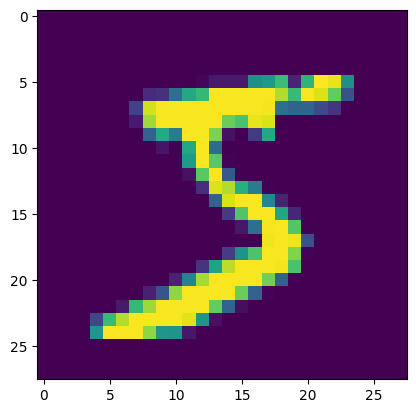

In [4]:
tmp = iter(train_dataset)
imgs, labels = next(tmp)

plt.imshow(imgs[0])

<br>

---

<br>

_**(Problem 1)**_ Define model, loss function and optimizer.
Design an autoencoder model using MLP and `nn.ReLU` as the activation function. The details of architecture are specified in the comments. Refer to the last class material and use `nn.Sequential` where possible. This makes the code more concise.

The loss function is the `nn.MSELoss` to account for reconstruction errors and optimizer is `optim.Adam` as before.

In [45]:
class AutoEncoder(nn.Module):
    def __init__(self, dim_in, act_func=nn.ReLU):
        super().__init__()
        self.E1 = nn.Linear(dim_in, 1000)
        self.relu = nn.ReLU()
        self.E2 = nn.Linear(1000, 25)
        self.E3 = nn.Linear(25, 50)
        self.D1 = nn.Linear(50, 1000)
        self.D2 = nn.Linear(1000, dim_in)

    def forward(self, x):
        x = self.relu(self.E1(x))
        x = self.relu(self.E2(x))
        x = self.relu(self.E3(x))
        x = self.relu(self.D1(x))
        x = self.D2(x)
        return x

    def encoder(self, x):
        x = self.relu(self.E1(x))
        x = self.relu(self.E2(x))
        x = self.relu(self.E3(x))
        return x


In [46]:
n_feat = 28*28

lr = 1e-3

model = AutoEncoder(n_feat).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-8)

losses = []

<br>

---

<br>

_**(Problem 2)**_ write your code to train model. It is very similar to the structure shown in the class materials. The goal is to optimize the model by minimizing the reconstruction loss `nn.MSELoss` using the `torch.optim.Adam`.

In [47]:
epoch = 200

model.train()
progress = tqdm(range(epoch))
criterion = nn.MSELoss()
for i in progress:
    ## your code here---------------------------##
    batch_loss = 0

    for (_in, tgt) in train_dataloader:
        ## tensor: CPU -> GPU
        _in = _in.to(device)
        tgt = tgt.to(device)
        #---------------------------------------#

        optimizer.zero_grad()
        _in = _in.view(_in.size(0), -1)
        out = model(_in)

        loss =criterion(out, _in)

        loss.backward()
        optimizer.step()
        batch_loss += loss.cpu().detach().item()

    losses.append(batch_loss / len(train_dataloader))
    ##------------------------------------------##

    progress.set_description(f"{losses[-1]:e}")


1.016214e-02: 100%|██████████| 200/200 [21:19<00:00,  6.40s/it]


Text(0.5, 1.0, 'Training Loss')

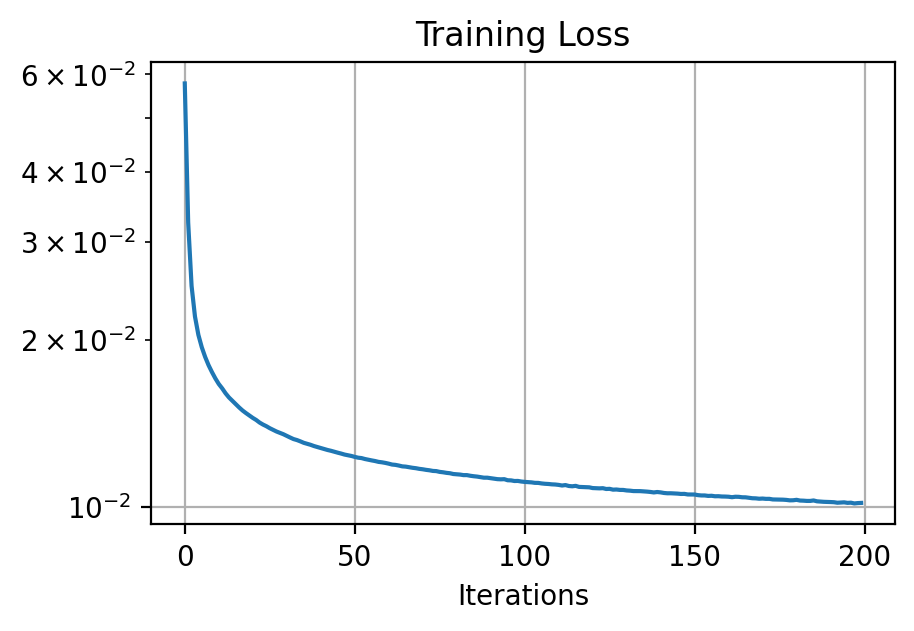

In [48]:
plt.figure(figsize=(1.6*3,1*3), dpi=200)

plt.semilogy(losses)
plt.grid()
plt.xlabel('Iterations')
plt.title('Training Loss')

To visualize the latent space representation learned by the autoencoder, we use t-SNE (t-Distributed Stochastic Neighbor Embedding). t-SNE is a popular technique for mapping high-dimensional data points to a lower-dimensional space, typically 2D or 3D, while preserving the structure of the data as much as possible.

To evaluate the quality of the learned latent space, we compare the 2D projections obtained by applying t-SNE on:
1. Latent Space: Representations generated by the encoder.
2. Original Space: The original input data (flattened MNIST images).

Since applying t-SNE to the entire test dataset is computationally expensive, we sample 1/3 of the data for visualization.

In [49]:
orgs = []; outs = []; labels = []

with torch.no_grad():
    for (_in, label) in train_dataloader:
        n_batch = len(_in)
        _in = _in.reshape(n_batch,-1).to(device)
        out = model.encoder(_in)
        outs.append(out)
        orgs.append(_in)
        labels.append(label)
    outs = torch.cat(outs).cpu().detach().numpy()
    orgs = torch.cat(orgs).cpu().detach().numpy()
    labels = torch.cat(labels).cpu().detach().numpy()

tsne = TSNE(n_components=2, random_state=3)

itv = 3

outs_tsne = tsne.fit_transform(outs[::itv])
orgs_tsne = tsne.fit_transform(orgs[::itv])

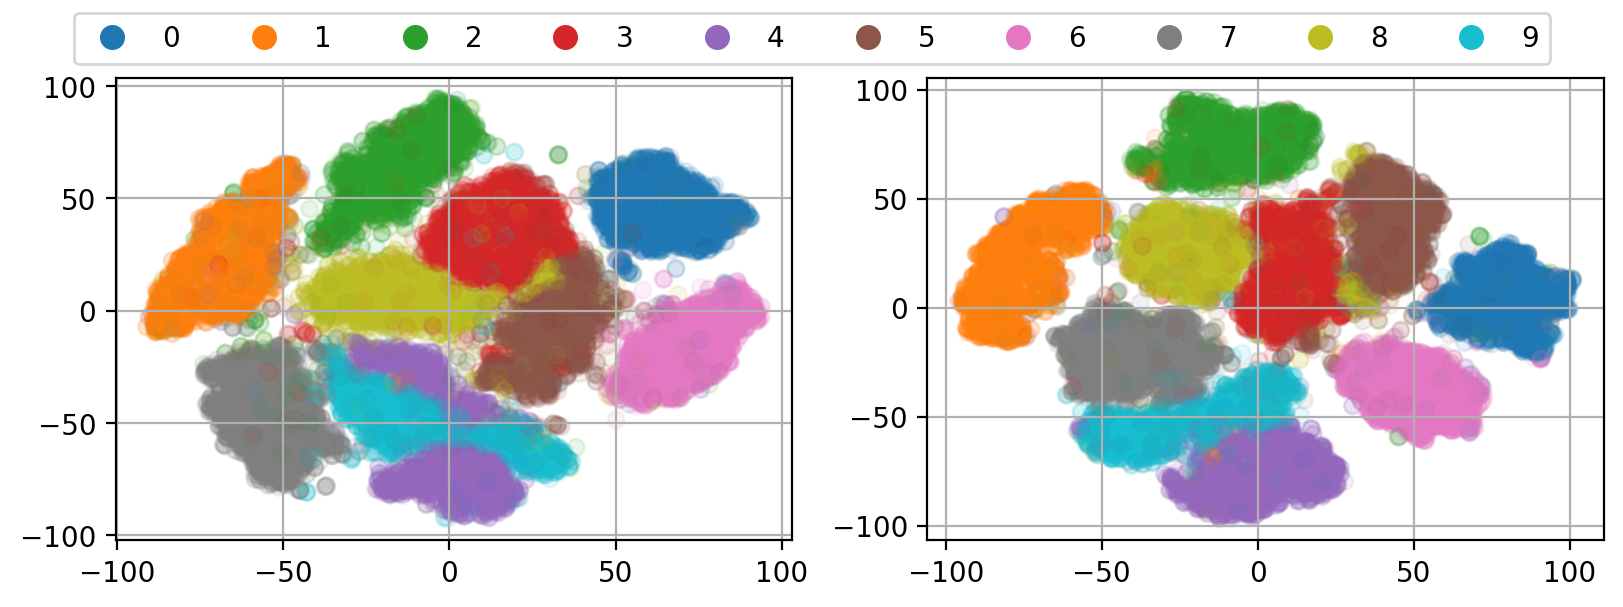

In [50]:
colors = [f'C{i}' for i in range(10)]

fig, axes = plt.subplots(1,2, figsize=(1.6*3*2,1*3), dpi=200)

ax = axes[0]
ax.scatter(*orgs_tsne.T, alpha=0.1, c=[colors[int(i)] for i in labels[::itv]])

ax = axes[1]
ax.scatter(*outs_tsne.T, alpha=0.1, c=[colors[int(i)] for i in labels[::itv]])


legend_handles = [
    plt.Line2D([0], [0], color=colors[i], marker='o', linestyle='None', markersize=8, label=f"{i}")
    for i in np.arange(10)]
fig.legend(handles=legend_handles, loc="upper center", ncol=10)

for ax in axes.flatten():
    ax.grid()

<br>

---

<br>

_**(Problem 3)**_
To classify a given input $x$, we use the cluster centers computed from the train dataset in both latent space and original space. The process involves the following steps:

1. Compute the mean vector (cluster center) for each class $c$ in latent space($\mu^\text{lat}$) and original space($\mu^\text{org}$) respectively.

2. Calculate 2-norm distances

$$
\begin{aligned}
d^\text{org}(x, \mu^\text{org}_c) &= \left\|x - \mu^\text{org}_c  \right\|_2\\
d^\text{lat}(z, \mu^\text{lat}_c) &= \left\|z - \mu^\text{lat}_c  \right\|_2
\end{aligned}
$$

3. Class Prediction by identifying the class $c^*$ which minimizes the distance in either space:
- In original space:
$$c^* = \underset{c}{\text{argmin}}(d^\text{org}(x, \mu_c^\text{org}))$$
- In latent space:
$$c^* = \underset{c}{\text{argmin}}(d^\text{lat}(x, \mu_c^\text{lat}))$$

In [51]:
print(np.shape(labels[::itv]))
print(np.shape(outs_tsne))

(20000,)
(20000, 2)


In [52]:
## your code here ##
# 배고프다
accuracy_orin = np.zeros((10,10))
accuracy_lat = np.zeros((10,10))
mean_mu_orin = np.zeros((10,2))
mean_mu_lat = np.zeros((10,2))
sum = np.zeros(10)

for i in range(len(labels[::itv])):
  label = labels[::itv][i]
  mean_mu_orin[label,:] += orgs_tsne[i,:]
  mean_mu_lat[label,:] += outs_tsne[i,:]
  sum[label] += 1
print(sum)
for i in range(len(mean_mu_orin)):
  mean_mu_orin[i] = 1/sum[i] * mean_mu_orin[i]
  mean_mu_lat[i] = 1/sum[i] * mean_mu_lat[i]

print(mean_mu_orin)
print(mean_mu_lat)




def argmin(inputs,mean_mu):
  norms = np.zeros(len(mean_mu))
  for i in range(len(mean_mu)):
    norms[i] = np.linalg.norm(mean_mu[i] - inputs)
  ind = np.where(norms == np.min(norms))
  return ind[0][0]




for i in range(len(orgs_tsne)):
  label = labels[::itv][i]
  la = argmin(orgs_tsne[i,:],mean_mu_orin)
  accuracy_orin[label][la] +=1

for i in range(len(outs_tsne)):
  label = labels[::itv][i]

  la = argmin(outs_tsne[i,:],mean_mu_lat)
  accuracy_lat[label][la] +=1
print(f"Accuracy in original space(%): {100 * np.trace(accuracy_orin)/np.sum(accuracy_orin)}")
print(f"Accuracy in latent space(%): {100* np.trace(accuracy_lat)/np.sum(accuracy_lat)}")







[1919. 2295. 2035. 2075. 1933. 1834. 1931. 2111. 1948. 1919.]
[[ 63.79430404  44.90224561]
 [-66.08299164  24.20902688]
 [-15.8022567   59.78970864]
 [ 13.36187474  32.56840013]
 [ -2.56675462 -56.72460541]
 [ 29.39596136  -9.66743851]
 [ 69.98174153 -16.06737965]
 [-52.76222365 -43.91358062]
 [-13.30078389   5.79793335]
 [ -5.06655257 -47.98939021]]
[[ 78.66986751   3.43191386]
 [-72.73673923  20.62533055]
 [ -8.32640635  72.64741077]
 [ 10.14629854  16.9961728 ]
 [ -0.90593221 -74.69543339]
 [ 40.52256895  34.7477911 ]
 [ 49.04722931 -36.47875302]
 [-38.46769276 -21.27064919]
 [-16.48965535  23.9644909 ]
 [-20.25796177 -48.48335061]]
Accuracy in original space(%): 84.24
Accuracy in latent space(%): 92.745


<br>

## Extension - Constrast Learning

In this project, we designed a classifier using an autoencoder. This approach is based on the intuition that the autoencoder's latent space can compress data meaningfully, forming distinct regions for each class. In addition to this, we aim to improve the structure of the latent space by incorporating Contrastive Learning.

Contrastive Learning is a technique within Self-Supervised Learning that compares data pairs (positive and negative pairs) to learn efficient representations. It encourages similar data (positive pairs) to be closer in the latent space, while dissimilar data (negative pairs) are pushed farther apart. It is widely used for learning effective representations from unlabeled data.

A representative example of Contrastive Loss is the NT-Xent Loss (Normalized Temperature-scaled Cross Entropy Loss), which is defined as follows:

$$\mathbf{L}_\text{contrastive} = -\log \frac{\exp(\text{sim}(z, z^+) / \tau)}{\exp(\text{sim}(z, z^+) / \tau) + \sum_{z^-} \exp(\text{sim}(z, z^-) / \tau)}$$

where,
- $\text{sim}$: The similarity metric between two vectors, typically cosine similarity.
- $\tau$: The temperature scaling parameter that controls the sharpness of the probability distribution.

For simplicity in this assignment, we focus on ensuring that dissimilar data are pushed farther apart in the latent space. This is achieved using the negative-only loss, defined as:

$$
\mathbf{L}_\text{contrastive} \approx \log \left( 1 + \sum_{z^-} \exp(\text{sim}(z, z^-) / \tau) \right)
$$


In [34]:
n_feat = 28*28

lr = 1e-3

model = AutoEncoder(n_feat).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-8)

losses = []

In [35]:
def constrastive_loss(z, z_neg, tau=0.5):
    """
    z: latent vector for selected class (batch, latent_dim)
    z_neg: negative latent vector for diffdrent class (batch, latent_dim)
    """
    z = F.normalize(z, dim=1)
    z_neg = F.normalize(z_neg, dim=1)

    sim = torch.sum(z * z_neg, dim=1)
    tmp = sim / tau

    loss = torch.log(1 + torch.exp(tmp))

    return loss.mean()


<br>

---

<br>

_**(Problem 4)**_ Write your code referring to the following pseudo-code. Add a loss function considering contrastive learning to the existing training code you wrote earlier. Use `contrastive_loss` to incorporate this functionality.

**Pseudo code**:
$$
\begin{array}{l}
\textbf{for } i\ \textbf{to } \text{max_iter } \textbf{do }\\
\quad \vdots \quad \text{Original training process}\\
\quad\textbf{select } a_1, a_2 \in [0,9]\\
\quad\textbf{if } \text{count_length}(a_1) \neq 0 \textbf{ and } \text{count_length}(a_2) \neq 0 \textbf{ then } \\
\qquad z \leftarrow \text{latent vectors corresponding to } a_1 ;\\
\qquad z_\text{neg} \leftarrow  \text{latent vectors corresponding to } a_2 ;
\\
\qquad \text{_len} \leftarrow \min(\text{count_length}(a_1), \text{count_length}(a_2)); \\
\qquad z \leftarrow z[:\text{_len}]; \\
\qquad z_\text{neg} \leftarrow z_\text{neg}[:\text{_len}]; \\
\qquad \text{loss_ ctr}\leftarrow \text{constrastive_loss}(z, z_\text{neg}); \\
\quad\textbf{end}\\
 \quad\textbf{else }\\
 \qquad \text{loss_ ctr}\leftarrow 0;\\
\quad\textbf{end if}\\
\quad \text{loss} \leftarrow \text{loss} + \text{loss_ctr};\\
\quad \vdots \quad \text{(Continue with backpropagation and optimization)} \\
\textbf{end for}
\end{array}
$$

In [41]:
epoch =200

model.train()
progress = tqdm(range(epoch))
criterion = nn.MSELoss()
for i in progress:
    ## your code here---------------------------##
    batch_loss = 0

    for (_in, tgt) in train_dataloader:
        ## tensor: CPU -> GPU
        _in = _in.to(device)
        tgt = tgt.to(device)
        #---------------------------------------#

        optimizer.zero_grad()
        _in = _in.view(_in.size(0), -1)
        #모델의 latent space에 있는 Z 벡터들 출력
        Zs = model(_in)
        loss =criterion(Zs, _in)
        a_1,a_2 = np.random.choice(range(9), size=2, replace=False)
        if len(Zs[tgt == a_1]) != 0 and len(Zs[tgt == a_2]) != 0:
          z = Zs[tgt == a_1]
          z_neg =  Zs[tgt == a_2]

          _len = min(len(Zs[tgt == a_1]),len(Zs[tgt == a_2]))
          z = z[:_len]
          z_neg = z_neg[:_len]
          loss_ctr = constrastive_loss(z, z_neg, tau=0.5)
        else:
          loss_ctr = 0
        loss += loss_ctr






        loss.backward()
        optimizer.step()
        batch_loss += loss.cpu().detach().item()

    losses.append(batch_loss / len(train_dataloader))
    ##------------------------------------------##

    progress.set_description(f"{losses[-1]:e}")



6.918306e-01: 100%|██████████| 200/200 [21:47<00:00,  6.54s/it]


In [42]:
model.eval()

outs = []; labels = []

with torch.no_grad():
    for (_in, label) in train_dataloader:
        n_batch = len(_in)
        _in = _in.reshape(n_batch,-1).to(device)
        out = model.encoder(_in)
        outs.append(out)
        labels.append(label)
    outs = torch.cat(outs).cpu().detach().numpy()
    labels = torch.cat(labels).cpu().detach().numpy()

tsne = TSNE(n_components=2, random_state=3)

itv = 3

outs_tsne = tsne.fit_transform(outs[::itv])


Text(0.5, 1.0, 'Autoencoder with Constrast Learning')

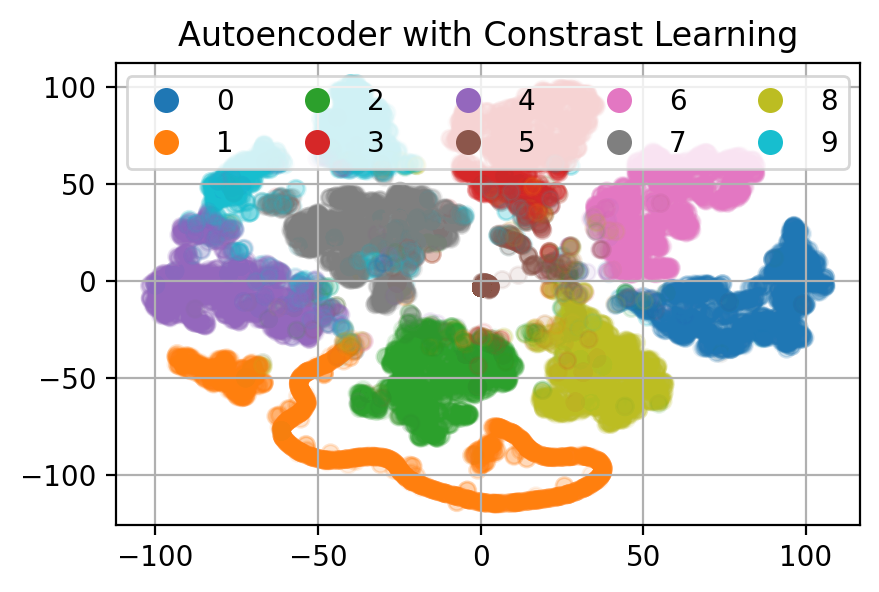

In [43]:
colors = [f'C{i}' for i in range(10)]

plt.figure(figsize=(1.6*3,1*3), dpi=200)

plt.scatter(*outs_tsne.T, alpha=0.1, c=[colors[int(i)] for i in labels[::itv]])

legend_handles = [
    plt.Line2D([0], [0], color=colors[i], marker='o', linestyle='None', markersize=8, label=f"{i}")
    for i in np.arange(10)]
plt.legend(handles=legend_handles, loc="upper center", ncol=5)

plt.grid()
plt.title('Autoencoder with Constrast Learning')

In [44]:
## your code here ##
# 배고프다
accuracy_lat = np.zeros((10,10))
mean_mu_lat = np.zeros((10,2))
sum = np.zeros(10)

for i in range(len(labels[::itv])):
  label = labels[::itv][i]
  mean_mu_lat[label,:] += outs_tsne[i,:]
  sum[label] += 1
print(sum)
for i in range(len(mean_mu_orin)):
  mean_mu_lat[i] = 1/sum[i] * mean_mu_lat[i]


print(mean_mu_lat)




def argmin(inputs,mean_mu):
  norms = np.zeros(len(mean_mu))
  for i in range(len(mean_mu)):
    norms[i] = np.linalg.norm(mean_mu[i] - inputs)
  ind = np.where(norms == np.min(norms))
  return ind[0][0]

for i in range(len(outs_tsne)):
  label = labels[::itv][i]

  la = argmin(outs_tsne[i,:],mean_mu_lat)
  accuracy_lat[label][la] +=1
print(f"Accuracy in latent space(%): {100* np.trace(accuracy_lat)/np.sum(accuracy_lat)}")


[2011. 2244. 1974. 2125. 1991. 1775. 1972. 2029. 1934. 1945.]
[[ 79.83106499 -10.78879789]
 [-29.50464628 -75.4651472 ]
 [-12.56663834 -48.72233717]
 [ 12.51959825  66.96158498]
 [-74.53086007  -3.07950681]
 [  2.61921778  -0.84639126]
 [ 56.13757716  37.67247995]
 [-33.11449509  22.83149328]
 [ 33.95035154 -42.98294023]
 [-46.76468733  56.84412498]]
Accuracy in latent space(%): 86.525
